In [1]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [13]:
training_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                               labels="inferred",
                                                               label_mode="categorical",
                                                               color_mode="rgb",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(224, 224),
                                                               batch_size=100)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                                labels="inferred",
                                                                label_mode="categorical",
                                                                color_mode="rgb",
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                seed=123,
                                                                image_size=(224, 224),
                                                                batch_size=100)

test_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/test",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            color_mode="rgb",
                                                            image_size=(224, 224),
                                                            batch_size = 100)



Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.
Found 624 files belonging to 3 classes.


In [3]:
import mlflow

run_id="434536936096303142"
model_uri="96eb2ef9dd4d4c2db56e348cfd6e9cef"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
artifact_uri = f"mlflow-artifacts:/{run_id}/{model_uri}/artifacts/finalized_model"

try:
    mlflow.artifacts.download_artifacts(
        artifact_uri=artifact_uri, dst_path="./models"
    )
except Exception as mlflow_error:
    raise mlflow_error

In [4]:
model_file = os.path.split(artifact_uri)[1]
model_file

'finalized_model'

In [5]:
model = tf.keras.models.load_model(f"./models/{model_file}")


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [40]:
model.input_shape[3]

3

In [60]:
pil_to_tensor = transforms.ToTensor()

dataset = "test"
category = "NORMAL"
image = "IM-0001-0001.jpeg"

file_path = f'data/data/{dataset}/{category}/{image}'
img_pil = Image.open(file_path)
img_pil = img_pil.convert("RGB")
img_pil = img_pil.resize((224,224))
img_tensor = pil_to_tensor(img_pil)
img_tensor = img_tensor.reshape(224,224,3)
img_tensor = tf.image.convert_image_dtype(img_tensor, dtype=tf.float32)

img_array_resized = tf.keras.preprocessing.image.array_to_img(img_tensor)
img_array_resized = img_array_resized.resize((224, 224))
img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)
img_array_resized.shape


(224, 224, 3)

In [34]:
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor.shape

(1, 224, 224, 3)

In [44]:
max(model.predict(img_tensor)[0])

1/1 [==============================] - 1s 722ms/step


0.61321265

In [42]:
model.predict(img_tensor).argmax(axis=1)[0]

1/1 [==============================] - 0s 330ms/step


2

In [14]:
img_arrays = []
# prediction_probs = np.empty((0,3), float)
predictions = np.array([])
labels =  np.array([])
# labels_encoded = np.empty((0,3), int)
for x, y in test_dataset:
  img_arrays = img_arrays + tf.unstack(x)
  prediction_prob = model.predict(x)
  # prediction_probs = np.vstack([prediction_probs, prediction_prob])
  predictions = np.concatenate([predictions, prediction_prob.argmax(axis=1)])
  # labels_encoded = np.vstack([labels_encoded, y.numpy()])
  labels = np.concatenate([labels, y.numpy().argmax(axis=1)])

1/1 [==============================] - 1s 666ms/step


In [56]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [45]:
list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))[-1].name

'Conv_1'

In [46]:
conv_layers = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))
len(conv_layers)

35

In [50]:
len(conv_layers[-35:])

35

In [52]:
import math
math.ceil(np.sqrt(35))

6

In [54]:
img_array = img_arrays[0]
img_array

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [ 86.320404,  86.320404,  86.320404],
        [ 88.9442  ,  88.9442  ,  88.9442  ],
        [ 83.036865,  83.036865,  83.036865]],

       [[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [ 87.      ,  87.      ,  87.      ],
        [ 92.017944,  92.017944,  92.017944],
        [ 91.03874 ,  91.03874 ,  91.03874 ]],

       [[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [ 89.32792 ,  89.32792 ,  89.32792 ],
        [ 91.279015,  91.279015,  91.279015],
        [101.91828 , 101.91828 , 101.91828 ]],

       ...,

       [[  0.      ,   0.      ,   0.      ],
        [  0.

1/1 [==============================] - 0s 96ms/step


C:\Users\angus\AppData\Local\Temp\ipykernel_19092\4146687471.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


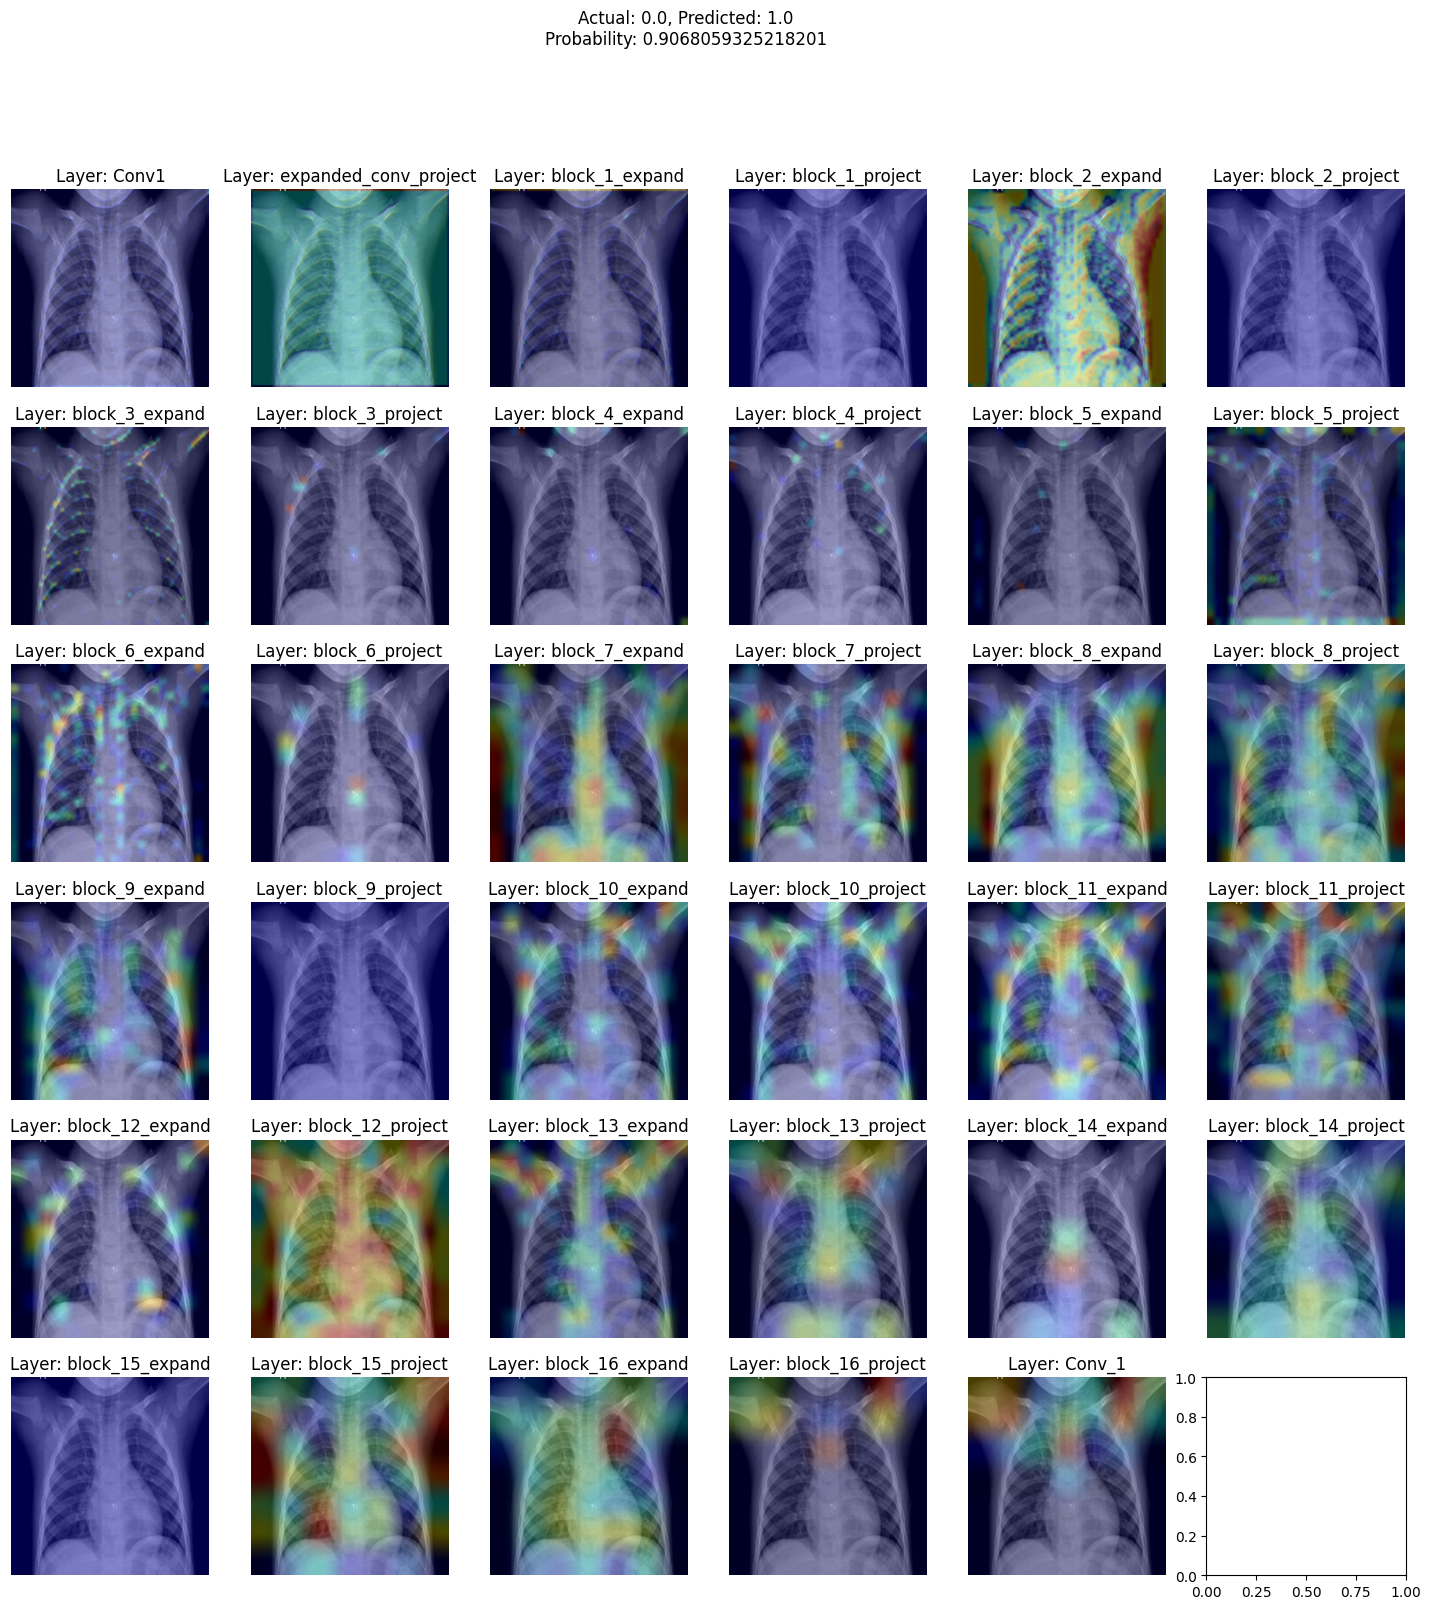

In [57]:

prediction_probs = np.array(model.predict(np.expand_dims(img_array, axis=0))[0])
prediction_prob = max(prediction_probs)
prediction = predictions[0]
label =  labels[0]
img_tensor = np.expand_dims(img_array, axis=0)

n=6
fig, axes = plt.subplots(n,n, figsize=(18,18))
fig.suptitle(f"Actual: {label}, Predicted: {prediction}\nProbability: {prediction_prob}")


for i in range(len(conv_layers)):

    conv_layer = conv_layers[i]
    conv_layer_name = conv_layer.name

    heatmap = make_gradcam_heatmap(img_tensor, model, conv_layer_name)
    heatmap = np.uint8(255 * heatmap)
    img_array_resized = tf.keras.preprocessing.image.array_to_img(img_array)
    img_array_resized = img_array_resized.resize((500, 500))
    img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)


    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array_resized.shape[0], img_array_resized.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array_resized
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    axes[i//n, i%n].imshow(superimposed_img)
    axes[i//n, i%n].set_title(f"Layer: {conv_layer_name}")
    axes[i//n, i%n].axis('off')

In [31]:
len(model.trainable_variables)

14

In [8]:
model.trainable=True

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [10]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))


Number of layers in the base model:  166


In [11]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

In [12]:
len(model.trainable_variables)

22

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [14]:
# https://keras.io/api/layers/normalization_layers/batch_normalization/
bn_layers = list(filter(lambda x: isinstance(x, tf.keras.layers.BatchNormalization), model.layers))
for layer in bn_layers:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [38]:
# As you are training a much larger model and want to readapt the pretrained weights,
# it is important to use a lower learning rate at this stage.
# Otherwise, your model could overfit very quickly.
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy','Precision','Recall','AUC'])

In [39]:
n_epochs=15
history = model.fit(training_dataset,
                    epochs=n_epochs,
                    validation_data=validation_dataset)


Epoch 1/15
42/42 [==============================] - 167s 4s/step - loss: 0.5674 - accuracy: 0.7498 - precision: 0.7682 - recall: 0.7244 - auc: 0.9071 - val_loss: 0.5183 - val_accuracy: 0.7795 - val_precision: 0.8016 - val_recall: 0.7555 - val_auc: 0.9226
Epoch 2/15
42/42 [==============================] - 156s 4s/step - loss: 0.5261 - accuracy: 0.7783 - precision: 0.7929 - recall: 0.7599 - auc: 0.9195 - val_loss: 0.5091 - val_accuracy: 0.7852 - val_precision: 0.8080 - val_recall: 0.7584 - val_auc: 0.9251
Epoch 3/15
42/42 [==============================] - 164s 4s/step - loss: 0.5259 - accuracy: 0.7767 - precision: 0.7911 - recall: 0.7532 - auc: 0.9195 - val_loss: 0.5171 - val_accuracy: 0.7824 - val_precision: 0.7945 - val_recall: 0.7526 - val_auc: 0.9234
Epoch 4/15
42/42 [==============================] - 154s 4s/step - loss: 0.5140 - accuracy: 0.7759 - precision: 0.7915 - recall: 0.7580 - auc: 0.9232 - val_loss: 0.5370 - val_accuracy: 0.7747 - val_precision: 0.7947 - val_recall: 0.749

Text(0.5, 1.0, 'Training and validation accuracy')

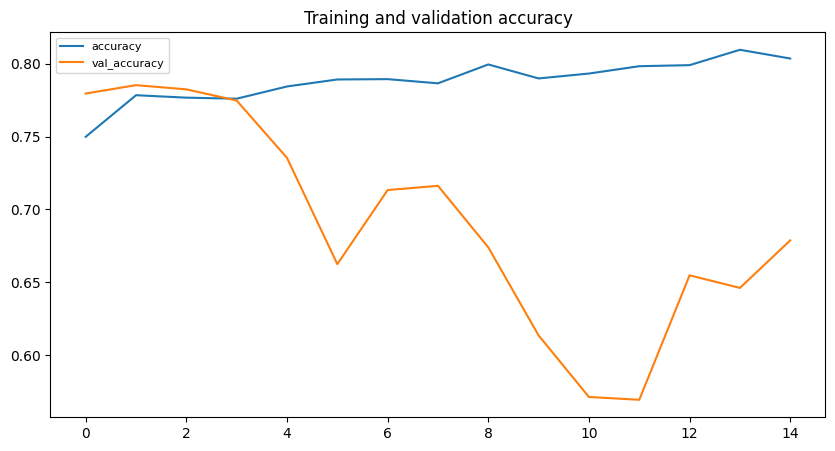

In [40]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(history_df["accuracy"], label="accuracy")
plt.plot(history_df["val_accuracy"], label='val_accuracy')
plt.legend(["accuracy", "val_accuracy"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation accuracy"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation precision')

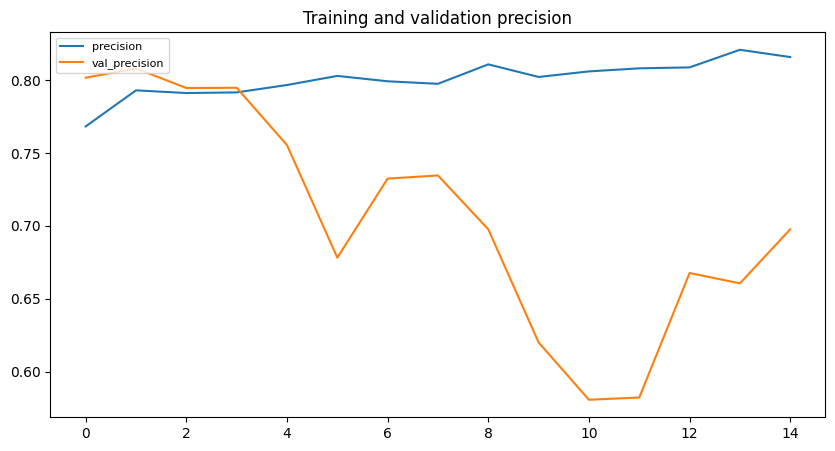

In [41]:
plt.figure(figsize=(10,5))
plt.plot(history_df["precision"], label="precision")
plt.plot(history_df["val_precision"], label='val_precision')
plt.legend(["precision", "val_precision"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation precision"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation recall')

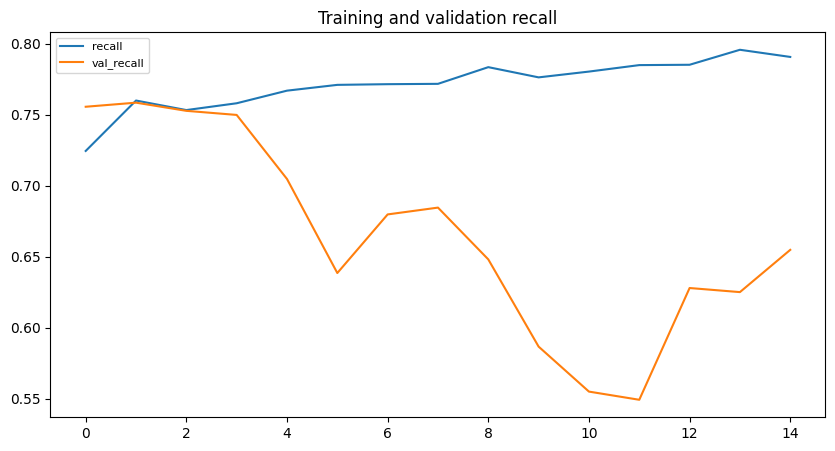

In [42]:
plt.figure(figsize=(10,5))
plt.plot(history_df["recall"], label="recall")
plt.plot(history_df["val_recall"], label='val_recall')
plt.legend(["recall", "val_recall"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation recall"
plt.title(plot_name)

In [43]:

model.evaluate(test_dataset)

7/7 [==============================] - 18s 2s/step - loss: 1.2851 - accuracy: 0.6042 - precision: 0.6360 - recall: 0.5769 - auc: 0.7590


[1.285107970237732,
 0.6041666865348816,
 0.6360424160957336,
 0.5769230723381042,
 0.7589899301528931]

In [76]:
def make_gradcam_heatmap(model, img_array, conv_layer_name, pred_index=None):
    """_summary_

    Args:
        img_array (_type_): _description_
        conv_layer (_type_): _description_
        pred_index (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # self.model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def generate_superimposed_image(img_array, heatmap, alpha=0.4):
    """_summary_

    Args:
        img_array (_type_): _description_
        heatmap (_type_): _description_
        alpha (float, optional): _description_. Defaults to 0.4.
    """
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[0], img_array.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


def generate_heatmaps_per_layer(model,
                                img_tensor,
                                predicted_class,
                                predicted_proba,
                                last_n,
                                conv_layers):

    last_n_conv_layers = conv_layers[-last_n:]
    last_n_conv_layers = list(reversed(last_n_conv_layers))
    n_plots = math.ceil(np.sqrt(len(last_n_conv_layers)))
    print(n_plots)

    fig, axes = plt.subplots(n_plots,n_plots, figsize=(18,18))
    plot_name = "Grad_CAM_Heatmap"
    title = "Grad-CAM Heatmap of last {} convolutional layers\nClass: {}\nProbability: {}".format(len(last_n_conv_layers), predicted_class, predicted_proba)
    fig.suptitle(title)

    for i in range(len(last_n_conv_layers)):

        conv_layer = last_n_conv_layers[i]
        conv_layer_name = conv_layer.name

        heatmap = make_gradcam_heatmap(model = model, img_array = np.expand_dims(img_tensor, axis=0), conv_layer_name = conv_layer_name)
        heatmap = np.uint8(255 * heatmap)
        img_array_resized = tf.keras.preprocessing.image.array_to_img(img_tensor)
        img_array_resized = img_array_resized.resize((500, 500))
        img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)
        superimposed_img = generate_superimposed_image(img_array = img_array_resized, heatmap = heatmap)

        axes[i//n_plots, i%n_plots].imshow(superimposed_img)
        axes[i//n_plots, i%n_plots].set_title(f"Layer: {conv_layer_name}")
        axes[i//n_plots, i%n_plots].axis('off')

In [100]:
dataset = "test"
category = "NORMAL"
image = "IM-0001-0001.jpeg"
classes = {0:"BACTERIA", 1:"NORMAL", 2:"VIRUS"}
last_n_layers = 14
conv_layers = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))

file_path = f'data/data/{dataset}/{category}/{image}'
img_pil = Image.open(file_path)
img_pil = img_pil.convert("RGB")
img_pil = img_pil.resize((224,224))
pil_to_tensor = transforms.ToTensor()
img_tensor = pil_to_tensor(img_pil)
img_tensor.shape




torch.Size([3, 224, 224])

In [101]:
img_tensor = img_tensor.permute(1, 2, 0)
img_tensor.shape

torch.Size([224, 224, 3])

In [106]:
img_tensor = tf.image.convert_image_dtype(img_tensor, dtype=tf.float32)

predicted_probas = model.predict(np.expand_dims(img_tensor, axis=0))
predicted_proba = max(predicted_probas[0])
predicted_class = classes[predicted_probas.argmax(axis=1)[0]]

1/1 [==============================] - 1s 725ms/step


In [107]:
last_n_conv_layers = conv_layers[-last_n_layers:]
last_n_conv_layers = list(reversed(last_n_conv_layers))
n_plots = math.ceil(np.sqrt(len(last_n_conv_layers)))

In [108]:
conv_layer = last_n_conv_layers[0]
conv_layer_name = conv_layer.name

heatmap = make_gradcam_heatmap(model = model, img_array = np.expand_dims(img_tensor, axis=0), conv_layer_name = conv_layer_name)
heatmap = np.uint8(255 * heatmap)



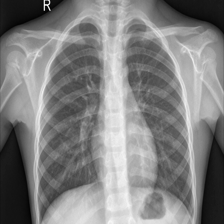

In [134]:
img_array_resized = tf.keras.preprocessing.image.array_to_img(img_tensor)
img_array_resized

In [135]:
img_array_resized = img_array_resized.resize((500, 500))
img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)
img_array_resized

array([[[23., 23., 23.],
        [23., 23., 23.],
        [25., 25., 25.],
        ...,
        [24., 24., 24.],
        [22., 22., 22.],
        [22., 22., 22.]],

       [[23., 23., 23.],
        [23., 23., 23.],
        [25., 25., 25.],
        ...,
        [24., 24., 24.],
        [22., 22., 22.],
        [22., 22., 22.]],

       [[23., 23., 23.],
        [23., 23., 23.],
        [25., 25., 25.],
        ...,
        [25., 25., 25.],
        [23., 23., 23.],
        [23., 23., 23.]],

       ...,

       [[20., 20., 20.],
        [20., 20., 20.],
        [22., 22., 22.],
        ...,
        [27., 27., 27.],
        [24., 24., 24.],
        [24., 24., 24.]],

       [[20., 20., 20.],
        [20., 20., 20.],
        [23., 23., 23.],
        ...,
        [27., 27., 27.],
        [24., 24., 24.],
        [24., 24., 24.]],

       [[20., 20., 20.],
        [20., 20., 20.],
        [23., 23., 23.],
        ...,
        [27., 27., 27.],
        [24., 24., 24.],
        [24., 24., 24.]]

In [136]:
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap


C:\Users\angus\AppData\Local\Temp\ipykernel_19092\1318495766.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


array([[[0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [2.24541429e-01, 1.00000000e+00, 7.43200506e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01]],

       [[0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [1.00000000e+00, 6.97893972e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-01]],

       [[4.74383302e-02, 9.58823529e-01, 9.20303605e-01],
        [1.00000000e+00, 6.83369644e-01, 0.00000000e+00],
        [5.00000000e-01, 0.00000000e+00, 0.00000000e+00],
        [9

In [137]:
(img_array_resized.shape[0], img_array_resized.shape[1])

(500, 500)

In [138]:
# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array_resized.shape[0], img_array_resized.shape[1]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)



In [139]:
# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img_array_resized
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

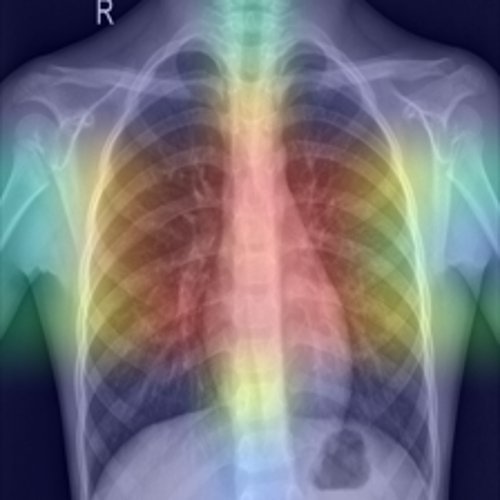

In [140]:
superimposed_img

4


C:\Users\angus\AppData\Local\Temp\ipykernel_19092\3150355952.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


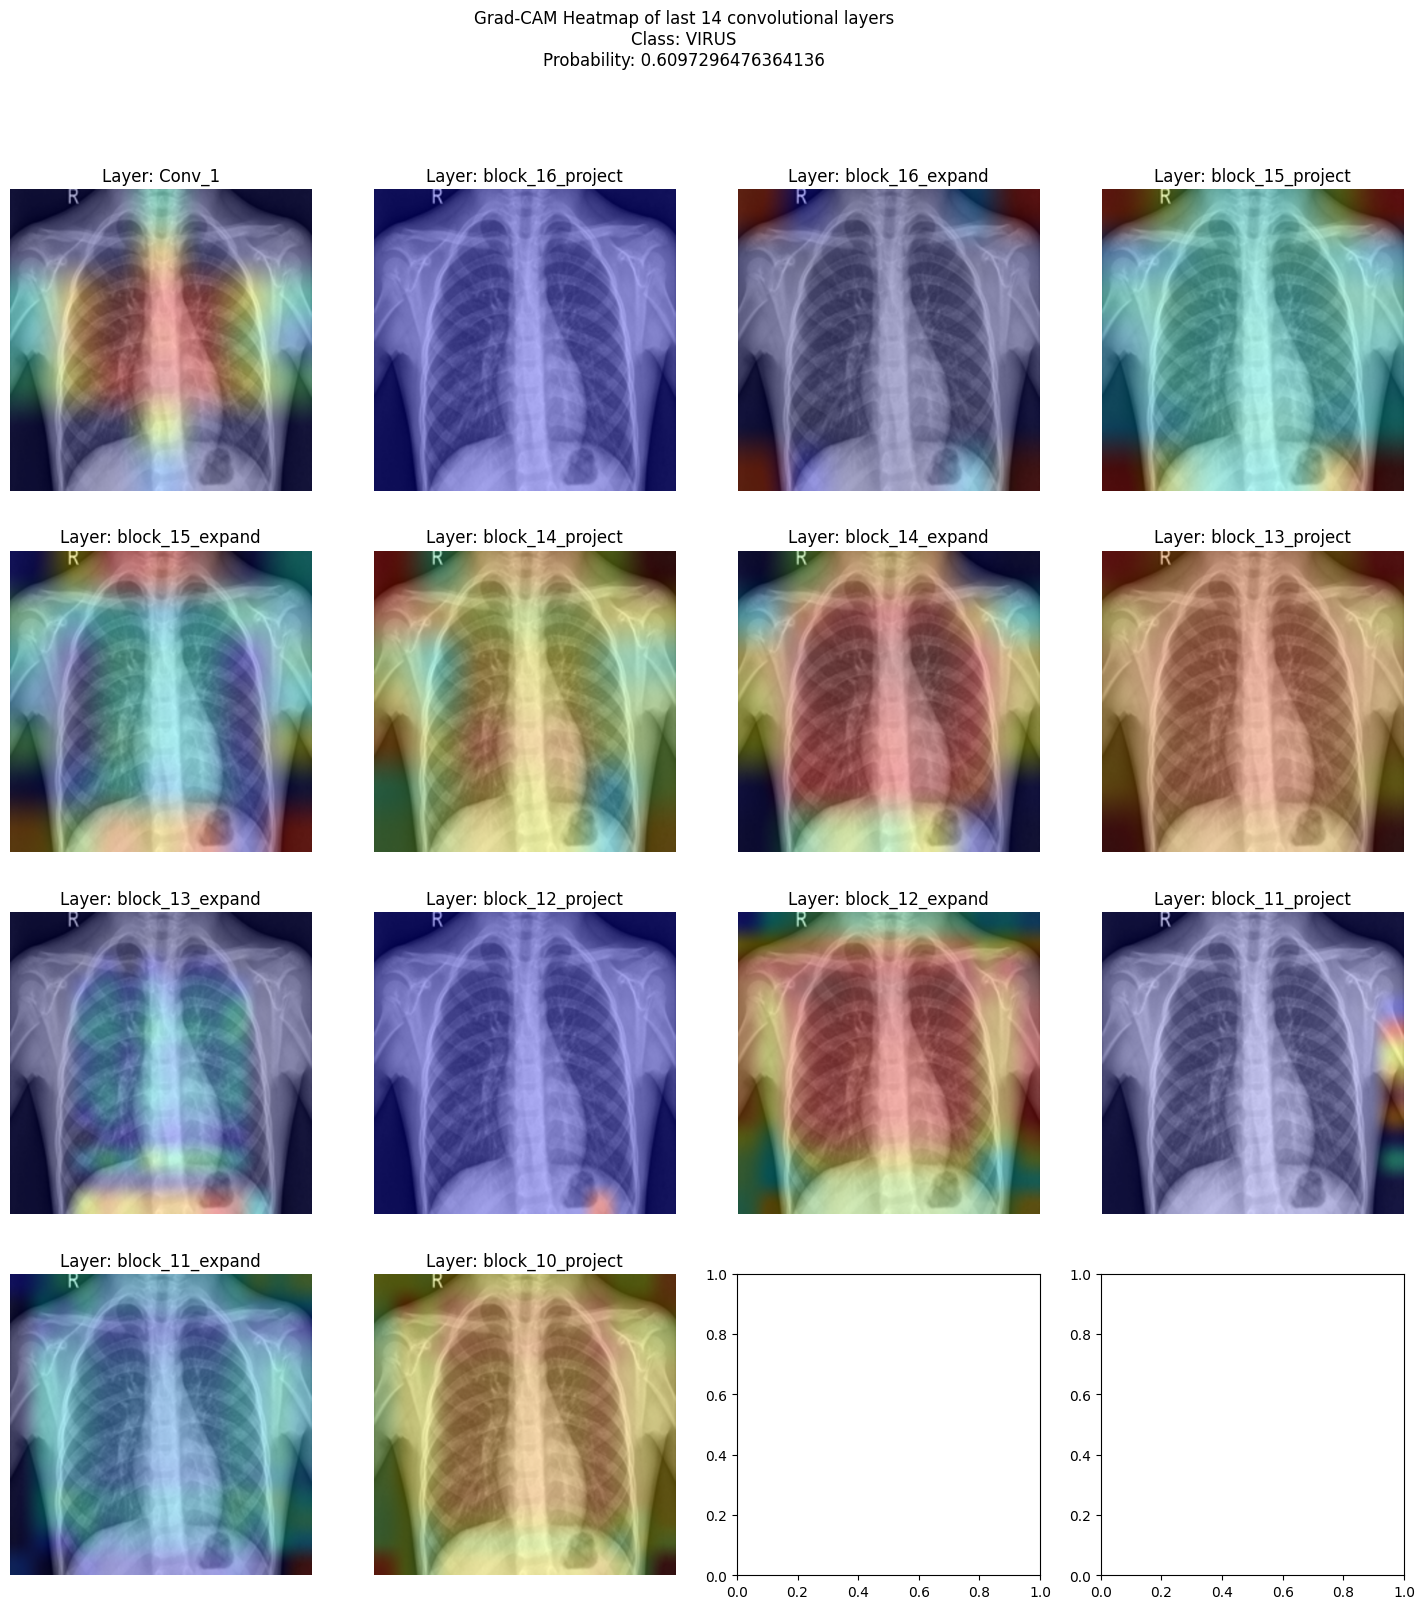

In [141]:
generate_heatmaps_per_layer(model = model,
                            img_tensor = img_tensor,
                            predicted_class = predicted_class,
                            predicted_proba = predicted_proba,
                            last_n = last_n_layers,
                            conv_layers = conv_layers)
